# Dataset Reading and Preprocessing

In [1]:
import os
import pandas as pd

column_names = ['edible?', 'cap-shape', 'cap-surface', 'cap-color', 'bruises?', 'odor',
               'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
               'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 
               'stalk-surface-below-ring', 'stalk-color-above-ring',
               'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
                'ring-type', 'spore-print-color', 'population', 'habitat']

data = pd.read_csv(os.path.join('..', 'data', 'agaricus-lepiota.data'), header=None, names=column_names)
data.head()

,edible?,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Replace missing data in column 11 (stalk-root) with mode

In [2]:
m11 = data.mode()['stalk-root'][0]
data.loc[data['stalk-root'] == '?', 'stalk-root'] = m11

## Encode nominal data to integers

In [3]:
from sklearn.preprocessing import LabelEncoder

categorical_data = data.apply(LabelEncoder().fit_transform)

# K-Folds Cross-Validation

In [4]:
from sklearn.model_selection import KFold

sets = KFold(n_splits=10)

# ID3 Tree Classification

Precision = 1.0
Recall = 1.0
F-Measure = 1.0


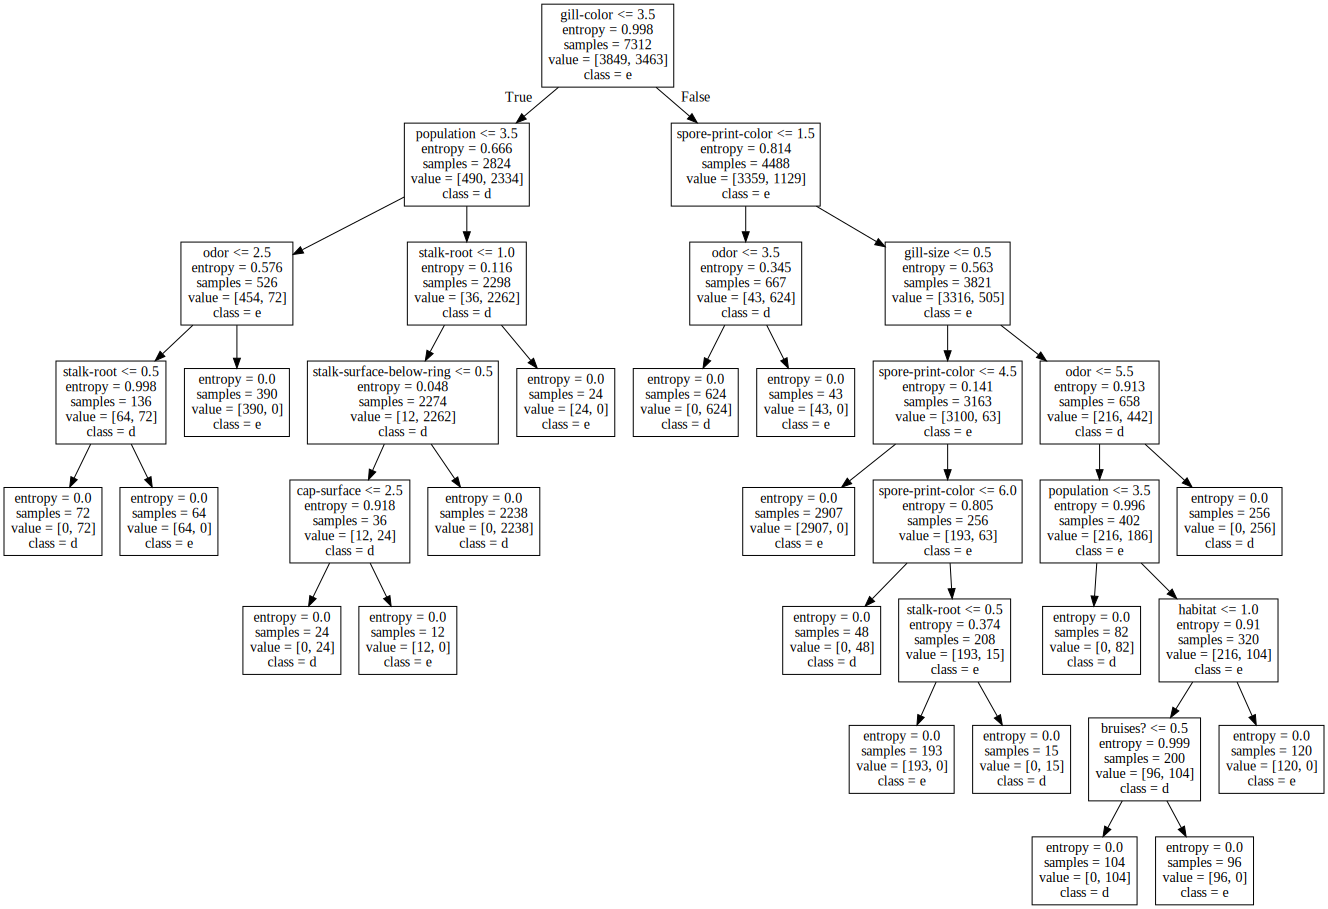

In [5]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import precision_recall_fscore_support

id3_tree, best_precision, best_recall, best_f1 = None, 0, 0, 0

for train_index, test_index in sets.split(data):
    X_train, X_test = categorical_data.iloc[train_index, 1:], categorical_data.iloc[test_index, 1:]
    y_train, y_test = data.iloc[train_index, 0], data.iloc[test_index, 0]
    dt = DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    presicion, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
    if f_measure >= best_f1:
        id3_tree, best_precision, best_recall, best_f1 = dt, presicion, recall, f_measure

graph = graphviz.Source(export_graphviz(id3_tree, feature_names=column_names[1:], class_names=column_names[0]))
print("Precision = {}".format(best_precision))
print("Recall = {}".format(best_recall))
print("F-Measure = {}".format(best_f1))
graph.render('ID3.gv')
graph

# CART Tree Classification

Precision = 1.0
Recall = 1.0
F-Measure = 1.0


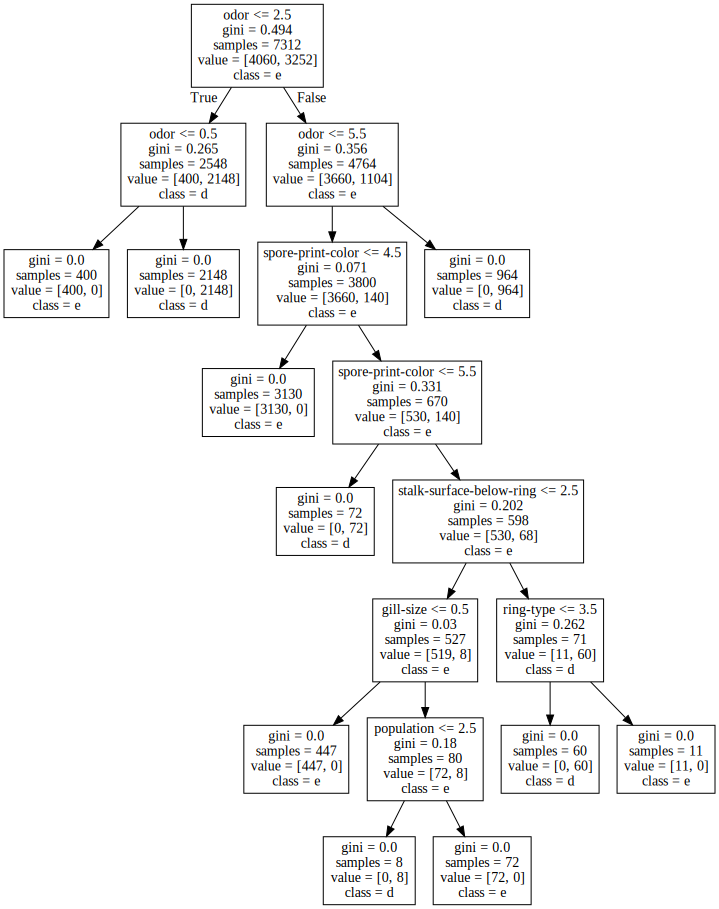

In [6]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import precision_recall_fscore_support

cart_tree, best_precision, best_recall, best_f1 = None, 0, 0, 0

for train_index, test_index in sets.split(data):
    X_train, X_test = categorical_data.iloc[train_index, 1:], categorical_data.iloc[test_index, 1:]
    y_train, y_test = data.iloc[train_index, 0], data.iloc[test_index, 0]
    dt = DecisionTreeClassifier(criterion='gini')
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_test)
    presicion, recall, f_measure, _ = precision_recall_fscore_support(y_test, y_pred, average='micro')
    if f_measure >= best_f1:
        cart_tree, best_precision, best_recall, best_f1 = dt, presicion, recall, f_measure

graph = graphviz.Source(export_graphviz(cart_tree, feature_names=column_names[1:], class_names=column_names[0]))
print("Precision = {}".format(best_precision))
print("Recall = {}".format(best_recall))
print("F-Measure = {}".format(best_f1))
graph.render('CART.gv')
graph

# Rule Extraction Using ID3 Tree

In [7]:
import numpy as np
from sklearn.tree._tree import TREE_UNDEFINED

def get_rules(tree):
    
    t = tree.tree_
    rules = []
    
    def dfs(node, conditions):
        if t.feature[node] != TREE_UNDEFINED:
            fname = column_names[t.feature[node] + 1]
            threshold = t.threshold[node]
            dfs(t.children_left[node], conditions + ["{} <= {}".format(fname, threshold)])
            dfs(t.children_right[node], conditions + ["{} > {}".format(fname, threshold)])
        else:
            class_name = tree.classes_[np.argmax(t.value[node])]
            rules.append("IF {} THEN edible = {}".format(' AND '.join(conditions), class_name))
    
    dfs(0, [])
    return rules

with open(os.path.join(os.getcwd(), 'RULES.txt'), 'w+') as f:
    rules = get_rules(id3_tree)
    print('\n'.join(rules))
    f.write('\n'.join(rules))

IF gill-color <= 3.5 AND population <= 3.5 AND odor <= 2.5 AND stalk-root <= 0.5 THEN edible = p
IF gill-color <= 3.5 AND population <= 3.5 AND odor <= 2.5 AND stalk-root > 0.5 THEN edible = e
IF gill-color <= 3.5 AND population <= 3.5 AND odor > 2.5 THEN edible = e
IF gill-color <= 3.5 AND population > 3.5 AND stalk-root <= 1.0 AND stalk-surface-below-ring <= 0.5 AND cap-surface <= 2.5 THEN edible = p
IF gill-color <= 3.5 AND population > 3.5 AND stalk-root <= 1.0 AND stalk-surface-below-ring <= 0.5 AND cap-surface > 2.5 THEN edible = e
IF gill-color <= 3.5 AND population > 3.5 AND stalk-root <= 1.0 AND stalk-surface-below-ring > 0.5 THEN edible = p
IF gill-color <= 3.5 AND population > 3.5 AND stalk-root > 1.0 THEN edible = e
IF gill-color > 3.5 AND spore-print-color <= 1.5 AND odor <= 3.5 THEN edible = p
IF gill-color > 3.5 AND spore-print-color <= 1.5 AND odor > 3.5 THEN edible = e
IF gill-color > 3.5 AND spore-print-color > 1.5 AND gill-size <= 0.5 AND spore-print-color <= 4.5 THE